In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
from backend.utils.frame import Frame
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.
NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.060 s)


In [4]:
import json
import datetime
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [6]:
def timings(seconds : int):
    # Total time on the pipeline.
    print(str(datetime.timedelta(seconds = seconds)))
    print(f"{seconds / 3600 :.2f} hours")

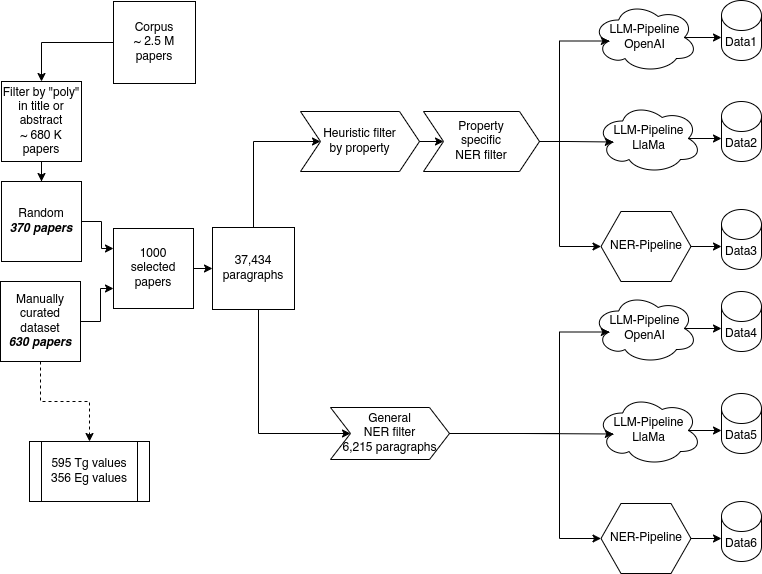

In [7]:
from IPython.display import Image
Image(filename="notebooks/Figure01.png")

In [7]:
# List of extraction methods.
execute("""select * from extraction_methods order by dataset""")

,name,dataset,model,api,para_subset,extraction_info,id,date_added
0,methanol_perm-ner-bert-sel1k,data3,materials-bert,None,methanol_perm-ner-sel1k,{'user': 'sonakshi'},37,2023-10-04 17:41:55.093514-04:00
1,o2_perm-ner-bert-sel1k,data3,materials-bert,None,o2_perm-ner-sel1k,{'user': 'sonakshi'},29,2023-10-04 17:33:03.594254-04:00
2,ri-ner-bert-sel1k,data3,materials-bert,None,ri-ner-sel1k,{'user': 'sonakshi'},30,2023-10-04 17:33:22.661102-04:00
3,ucst-ner-bert-sel1k,data3,materials-bert,None,ucst-ner-sel1k,{'user': 'sonakshi'},31,2023-10-04 17:33:59.146027-04:00
4,wca-ner-bert-sel1k,data3,materials-bert,None,wca-ner-sel1k,{'user': 'sonakshi'},32,2023-10-04 17:34:23.192498-04:00
5,wu-ner-bert-sel1k,data3,materials-bert,None,wu-ner-sel1k,{'user': 'sonakshi'},33,2023-10-04 17:34:49.654194-04:00
6,sd-ner-bert-sel1k,data3,materials-bert,None,sd-ner-sel1k,{'user': 'sonakshi'},34,2023-10-04 17:37:55.918709-04:00
7,density-ner-bert-sel1k,data3,materials-bert,None,density-ner-sel1k,{'user': 'sonakshi'},35,2023-10-04 17:40:01.350925-04:00
8,iec-ner-bert-sel1k,data3,materials-bert,None,iec-ner-sel1k,{'user': 'sonakshi'},36,2023-10-04 17:41:06.819525-04:00
9,co2_perm-ner-bert-sel1k,data3,materials-bert,None,co2_perm-ner-sel1k,{'user': 'sonakshi'},23,2023-10-04 17:29:00.216132-04:00


In [8]:
# Number of selected papers.
execute("""
    SELECT count(*) FROM filtered_papers fp 
    WHERE fp.filter_name = 'select-1k';
""")

,count
0,1000


In [9]:
# Number of the selected papers from the curated dataset.
execute("""
SELECT count(*) FROM filtered_papers fp 
WHERE fp.filter_name = 'select-1k'
AND EXISTS (
	SELECT 1 FROM curated_data cd 
	WHERE cd.doi = fp.doi
);""")

,count
0,630


In [10]:
# Number of paragraphs from the select 1k.
execute("""
    SELECT count(*) FROM paper_texts pt 
    JOIN filtered_papers fp ON fp.doi = pt.doi 
    WHERE fp.filter_name = 'select-1k';
""")

,count
0,37434


## Data6 - General NER - NER Pipeline.

In [12]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where dataset = 'data6';
""")[0]
method

Row(name='g-ner-bert-sel1k', dataset='data6', model='materials-bert', api=None, para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak'}, id=5, date_added=datetime.datetime(2023, 9, 26, 8, 56, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [13]:
# Number of paragraphs that passed the General NER filter.
execute("""
        SELECT count(*) FROM filtered_paragraphs fp 
        WHERE fp.filter_name = :method_para;
        
        """, method_para = method.para_subset)

,count
0,6215


In [14]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,9106


In [15]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,16368


In [16]:
# F1-score for Tg.
with open("runs/select-1k/bert/tg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-bert-sel1k', 'material': {'true_positives': 701, 'false_positives': 77, 'false_negatives': 146, 'precision': 0.9010282776349614, 'recall': 0.8276269185360094, 'F1': 0.8627692307692308}, 'value': {'true_positives': 544, 'false_positives': 234, 'false_negatives': 46, 'precision': 0.699228791773779, 'recall': 0.9220338983050848, 'F1': 0.7953216374269008}, 'property': {'true_positives': 432, 'false_positives': 346, 'false_negatives': 161, 'precision': 0.5552699228791774, 'recall': 0.7284991568296796, 'F1': 0.6301969365426696}}


In [17]:
# F1-score for Bandgap.
with open("runs/select-1k/bert/eg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-bert-sel1k', 'material': {'true_positives': 332, 'false_positives': 21, 'false_negatives': 118, 'precision': 0.9405099150141643, 'recall': 0.7377777777777778, 'F1': 0.8268991282689913}, 'value': {'true_positives': 317, 'false_positives': 36, 'false_negatives': 23, 'precision': 0.8980169971671388, 'recall': 0.9323529411764706, 'F1': 0.9148629148629148}, 'property': {'true_positives': 233, 'false_positives': 120, 'false_negatives': 121, 'precision': 0.660056657223796, 'recall': 0.6581920903954802, 'F1': 0.659123055162659}}


In [18]:
# Time for filtering.
!grep "All done." runs/select-1k/filter/*.log

[23-09-26 EDT 08:57:06 AM] NOTE  -- All done. (took 2516.329 s)


In [19]:
# Time for extraction.
!grep "All done." runs/select-1k/bert/ner-filtered*.log

runs/select-1k/bert/ner-filtered.01.log:[23-09-27 EDT 02:59:47 PM] NOTE  -- All done. (took 42.097 s)
runs/select-1k/bert/ner-filtered.log:[23-09-27 EDT 03:43:35 PM] NOTE  -- All done. (took 2254.671 s)


In [15]:
# Time for scoring.
!grep "All done." runs/select-1k/bert/metrics.log

[23-09-30 EDT 08:21:22 AM] NOTE  -- All done. (took 21.939 s)


In [16]:
timings(2516 + 42 + 2254 + 21)

1:20:33
1.34 hours


## Data5 - General NER - LlaMa 2 Pipeline.

In [11]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where name = 'g-ner-llama2-rand-sel1k';
""")[0]
method

Row(name='g-ner-llama2-rand-sel1k', dataset='data5', model='llama2-70B-chat', api='polyai', para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak', 'shot_selector': 'random', 'n_shots': 1, 'api_retry_delay': 60, 'delay_multiplier': 0.5, 'max_api_retries': 1, 'api_request_delay': 0.01, 'temperature': 0.001, 'prompt_id': 0, 'prompt': "Extract all numbers in JSONL format with 'material', 'property', 'value', 'condition' columns.", 'property': None, 'shot_nrecords': 2, 'shot_keywords': False}, id=10, date_added=datetime.datetime(2023, 9, 26, 8, 54, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [12]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,12641


In [13]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,20825


In [14]:
# Number of tokens.
df = execute("""
             SELECT para_id, request_tokens, response_tokens, request_tokens + response_tokens AS total_tokens
             FROM  api_requests ar WHERE ar.method_id = :mid;
             
             """, mid=method.id)

df['api_cost'] = 0

print(f"Total tokens: {df['total_tokens'].sum():,}")
print(f"Total cost: $ {df['api_cost'].sum():.2f}")
print(f"Number of requests: {df.shape[0]:,}")
df

Total tokens: 7,084,245.0
Total cost: $ 0.00
Number of requests: 6,215


,para_id,request_tokens,response_tokens,total_tokens,api_cost
0,7861428,1198.0,98.0,1296.0,0
1,17590351,1156.0,164.0,1320.0,0
2,7865501,1171.0,178.0,1349.0,0
3,26610330,1024.0,113.0,1137.0,0
4,11278120,1212.0,234.0,1446.0,0
...,...,...,...,...,...
6210,26754210,711.0,46.0,757.0,0
6211,26754211,789.0,178.0,967.0,0
6212,26784396,1131.0,198.0,1329.0,0
6213,26784403,840.0,149.0,989.0,0


In [16]:
# Number of failed requests
execute("""
        SELECT count(*) FROM api_requests ar
        WHERE ar.method_id = :mid AND status != 'ok';

        """, mid=method.id)

,count
0,4


In [17]:
# Time for extraction.
!grep "All done." runs/select-1k/llama2-rand/llm-pipeline*.log

runs/select-1k/llama2-rand/llm-pipeline.01.log:[23-10-01 EDT 02:27:00 PM] NOTE  -- All done. (took 4893.190 s)
runs/select-1k/llama2-rand/llm-pipeline.02.log:[23-10-02 EDT 02:22:31 PM] NOTE  -- All done. (took 57520.373 s)
runs/select-1k/llama2-rand/llm-pipeline.03.log:[23-10-02 EDT 04:07:04 PM] NOTE  -- All done. (took 5321.607 s)
runs/select-1k/llama2-rand/llm-pipeline.04.log:[23-10-03 EDT 06:32:10 AM] NOTE  -- All done. (took 50573.198 s)
runs/select-1k/llama2-rand/llm-pipeline.log:[23-10-05 EDT 02:39:31 PM] NOTE  -- All done. (took 188452.338 s)


In [19]:
# Time for scoring.
!grep "All done." runs/select-1k/llama2-rand/metrics.log

[23-10-05 EDT 03:31:27 PM] NOTE  -- All done. (took 20.079 s)


In [20]:
timings(4893+57520+5321+50573+188452+20)

3 days, 13:12:59
85.22 hours


In [21]:
# F1-score for Tg.
with open("runs/select-1k/llama2-rand/tg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-llama2-rand-sel1k', 'material': {'true_positives': 508, 'false_positives': 225, 'false_negatives': 170, 'precision': 0.6930422919508867, 'recall': 0.7492625368731564, 'F1': 0.7200566973777461}, 'value': {'true_positives': 491, 'false_positives': 242, 'false_negatives': 118, 'precision': 0.669849931787176, 'recall': 0.80623973727422, 'F1': 0.7317436661698957}, 'property': {'true_positives': 385, 'false_positives': 348, 'false_negatives': 213, 'precision': 0.5252387448840382, 'recall': 0.6438127090301003, 'F1': 0.578512396694215}}


In [22]:
# F1-score for Eg.
with open("runs/select-1k/llama2-rand/eg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-llama2-rand-sel1k', 'material': {'true_positives': 300, 'false_positives': 70, 'false_negatives': 67, 'precision': 0.8108108108108109, 'recall': 0.8174386920980926, 'F1': 0.814111261872456}, 'value': {'true_positives': 317, 'false_positives': 53, 'false_negatives': 49, 'precision': 0.8567567567567568, 'recall': 0.8661202185792349, 'F1': 0.8614130434782608}, 'property': {'true_positives': 283, 'false_positives': 87, 'false_negatives': 75, 'precision': 0.7648648648648648, 'recall': 0.7905027932960894, 'F1': 0.7774725274725276}}


## Data4 - General NER - GPT 3.5 Pipeline.

In [11]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where name = 'g-ner-gpt35-rand-sel1k';
""")[0]
method

Row(name='g-ner-gpt35-rand-sel1k', dataset='data4', model='gpt-3.5-turbo', api='openai', para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak', 'shot_selector': 'random', 'n_shots': 1, 'api_retry_delay': 5, 'delay_multiplier': 2.0, 'max_api_retries': 1, 'api_request_delay': 0.2, 'temperature': 0.001, 'prompt_id': 0, 'prompt': "Extract all numbers in JSONL format with 'material', 'property', 'value', 'condition' columns.", 'property': None, 'shot_nrecords': 2}, id=3, date_added=datetime.datetime(2023, 9, 26, 8, 53, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [12]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,16191


In [13]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,29516


In [14]:
# Number of tokens.
df = execute("""
             SELECT para_id, request_tokens, response_tokens, request_tokens + response_tokens AS total_tokens
             FROM  api_requests ar WHERE ar.method_id = :mid;
             
             """, mid=method.id)

df['api_cost'] = (0.0015 * df['request_tokens'] + 0.002 * df['response_tokens']) / 1000

print(f"Total tokens: {df['total_tokens'].sum():,}")
print(f"Total cost: $ {df['api_cost'].sum():.2f}")
print(f"Number of requests: {df.shape[0]:,}")
df

Total tokens: 7,151,891
Total cost: $ 11.42
Number of requests: 6,215


,para_id,request_tokens,response_tokens,total_tokens,api_cost
0,13513075,923,80,1003,0.001545
1,5852577,1292,189,1481,0.002316
2,7865819,978,92,1070,0.001651
3,16932019,879,26,905,0.001370
4,13719192,779,41,820,0.001251
...,...,...,...,...,...
6210,26754210,623,97,720,0.001129
6211,26754211,1036,101,1137,0.001756
6212,26784396,802,295,1097,0.001793
6213,26784403,868,205,1073,0.001712


In [15]:
# Number of failed requests
execute("""
        SELECT count(*) FROM api_requests ar
        WHERE ar.method_id = :mid AND status != 'ok';

        """, mid=method.id)

,count
0,0


In [16]:
# F1-score for Tg.
with open("runs/select-1k/gpt35-rand/tg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-gpt35-rand-sel1k', 'material': {'true_positives': 546, 'false_positives': 211, 'false_negatives': 137, 'precision': 0.7212681638044914, 'recall': 0.7994143484626647, 'F1': 0.7583333333333334}, 'value': {'true_positives': 543, 'false_positives': 214, 'false_negatives': 69, 'precision': 0.7173051519154557, 'recall': 0.8872549019607843, 'F1': 0.7932797662527391}, 'property': {'true_positives': 441, 'false_positives': 316, 'false_negatives': 157, 'precision': 0.582562747688243, 'recall': 0.7374581939799331, 'F1': 0.6509225092250922}}


In [17]:
# F1-score for Bandgap.
with open("runs/select-1k/gpt35-rand/eg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-gpt35-rand-sel1k', 'material': {'true_positives': 302, 'false_positives': 45, 'false_negatives': 64, 'precision': 0.8703170028818443, 'recall': 0.825136612021858, 'F1': 0.847124824684432}, 'value': {'true_positives': 311, 'false_positives': 36, 'false_negatives': 47, 'precision': 0.8962536023054755, 'recall': 0.8687150837988827, 'F1': 0.8822695035460992}, 'property': {'true_positives': 285, 'false_positives': 62, 'false_negatives': 71, 'precision': 0.8213256484149856, 'recall': 0.800561797752809, 'F1': 0.8108108108108109}}


In [18]:
# Time for extraction.
!grep "All done." runs/select-1k/gpt35-rand/llm-pipeline*.log

runs/select-1k/gpt35-rand/llm-pipeline.01.log:[23-09-29 EDT 02:19:54 AM] NOTE  -- All done. (took 15204.971 s)
runs/select-1k/gpt35-rand/llm-pipeline.log:[23-09-30 EDT 01:44:11 AM] NOTE  -- All done. (took 59576.347 s)


In [19]:
# Time for scoring.
!grep "All done." runs/select-1k/gpt35-rand/metrics.log

[23-09-30 EDT 08:22:04 AM] NOTE  -- All done. (took 21.206 s)


In [20]:
timings(15204+59576+21)

20:46:41
20.78 hours


In [34]:
postgres.disconnect()

## Data4 - General NER - GPT 3.5 - Similar Pipeline.

In [27]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where name = 'g-ner-gpt35-similar-sel1k';
""")[0]
method

Row(name='g-ner-gpt35-similar-sel1k', dataset='data4', model='gpt-3.5-turbo', api='openai', para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak', 'shot_selector': 'similar', 'n_shots': 1, 'api_retry_delay': 5, 'delay_multiplier': 2.0, 'max_api_retries': 1, 'api_request_delay': 0.2, 'temperature': 0.001, 'prompt_id': 0, 'prompt': "Extract all numbers in JSONL format with 'material', 'property', 'value', 'condition' columns.", 'property': None, 'shot_nrecords': 2, 'shot_keywords': False}, id=12, date_added=datetime.datetime(2023, 10, 4, 9, 48, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [28]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,15800


In [29]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,29282


In [30]:
# Number of tokens.
df = execute("""
             SELECT para_id, request_tokens, response_tokens, request_tokens + response_tokens AS total_tokens
             FROM  api_requests ar WHERE ar.method_id = :mid;
             
             """, mid=method.id)

df['api_cost'] = (0.0015 * df['request_tokens'] + 0.002 * df['response_tokens']) / 1000

print(f"Total tokens: {df['total_tokens'].sum():,}")
print(f"Total cost: $ {df['api_cost'].sum():.2f}")
print(f"Number of requests: {df.shape[0]:,}")
df

Total tokens: 6,381,634
Total cost: $ 10.24
Number of requests: 6,215


,para_id,request_tokens,response_tokens,total_tokens,api_cost
0,11163019,750,100,850,0.001325
1,13068056,899,98,997,0.001545
2,15711490,801,79,880,0.001360
3,7864862,1238,246,1484,0.002349
4,7865824,906,138,1044,0.001635
...,...,...,...,...,...
6210,26754210,590,97,687,0.001079
6211,26754211,780,107,887,0.001384
6212,26784396,795,328,1123,0.001849
6213,26784403,638,196,834,0.001349


In [31]:
# Number of failed requests
execute("""
        SELECT count(*) FROM api_requests ar
        WHERE ar.method_id = :mid AND status != 'ok';

        """, mid=method.id)

,count
0,0


In [33]:
# F1-score for Tg.
with open("runs/select-1k/gpt35-similar/tg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-gpt35-similar-sel1k', 'material': {'true_positives': 547, 'false_positives': 189, 'false_negatives': 134, 'precision': 0.7432065217391305, 'recall': 0.8032305433186491, 'F1': 0.7720536344389556}, 'value': {'true_positives': 530, 'false_positives': 206, 'false_negatives': 76, 'precision': 0.720108695652174, 'recall': 0.8745874587458746, 'F1': 0.789865871833085}, 'property': {'true_positives': 446, 'false_positives': 290, 'false_negatives': 150, 'precision': 0.6059782608695652, 'recall': 0.7483221476510067, 'F1': 0.6696696696696697}}


In [34]:
# F1-score for Eg.
with open("runs/select-1k/gpt35-similar/eg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-gpt35-similar-sel1k', 'material': {'true_positives': 315, 'false_positives': 46, 'false_negatives': 53, 'precision': 0.8725761772853186, 'recall': 0.8559782608695652, 'F1': 0.8641975308641975}, 'value': {'true_positives': 323, 'false_positives': 38, 'false_negatives': 35, 'precision': 0.8947368421052632, 'recall': 0.9022346368715084, 'F1': 0.8984700973574409}, 'property': {'true_positives': 301, 'false_positives': 60, 'false_negatives': 55, 'precision': 0.8337950138504155, 'recall': 0.8455056179775281, 'F1': 0.8396094839609484}}


In [35]:
# Time for extraction.
!grep "All done." runs/select-1k/gpt35-similar/llm-pipeline*.log

runs/select-1k/gpt35-similar/llm-pipeline.01.log:[23-10-04 EDT 10:31:33 AM] NOTE  -- All done. (took 2440.726 s)
runs/select-1k/gpt35-similar/llm-pipeline.log:[23-10-05 EDT 07:15:52 PM] NOTE  -- All done. (took 112354.174 s)


In [36]:
# Time for scoring.
!grep "All done." runs/select-1k/gpt35-rand/metrics.log

[23-09-30 EDT 08:22:04 AM] NOTE  -- All done. (took 21.206 s)


In [37]:
timings(2440+112354+21)

1 day, 7:53:35
31.89 hours


## Data3 - Property-specific NER - BERT Pipeline.

In [9]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where dataset = 'data3';
""")
method

[Row(name='co2_perm-ner-bert-sel1k', dataset='data3', model='materials-bert', api=None, para_subset='co2_perm-ner-sel1k', extraction_info={'user': 'sonakshi'}, id=23, date_added=datetime.datetime(2023, 10, 4, 17, 29, 0, 216132, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000)))),
 Row(name='ct-ner-bert-sel1k', dataset='data3', model='materials-bert', api=None, para_subset='ct-ner-sel1k', extraction_info={'user': 'sonakshi'}, id=24, date_added=datetime.datetime(2023, 10, 4, 17, 29, 57, 361218, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000)))),
 Row(name='dc-ner-bert-sel1k', dataset='data3', model='materials-bert', api=None, para_subset='dc-ner-sel1k', extraction_info={'user': 'sonakshi'}, id=25, date_added=datetime.datetime(2023, 10, 4, 17, 30, 20, 906013, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000)))),
 Row(name='h2_perm-ner-bert-sel1k', dataset='data3', model='materials-bert', api=None, para_subset='h2_perm-ner-sel1k', ex

In [ ]:
# Number of paragraphs that passed the property specific NER filter.
execute("""
        SELECT count(*) FROM filtered_paragraphs fp 
        WHERE fp.filter_name = :method_para;
        
        """, method_para = method.para_subset)

In [19]:
db.rollback()

In [11]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id >= 8 and em.method_id <= 37 and em.method_id != 10;
        """)

,count
0,20439


In [12]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id >= 8 and ep.method_id <= 37 and ep.method_id != 10;
        
        """)

,count
0,39014


In [14]:
def execute_count(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    count = results[0][0]
    return count

In [11]:
id_name = {8: 'glass transition temperature',
    9: 'bandgap',
    11: 'melting temperature',
    13: 'compressive strength',
    14: 'elongation at break',
    15: 'flexural strength',
    16: 'hardness',
    17: 'impact strength',
    18: 'thermal conductivity',
    19: 'thermal decomposition temperature',
    20: 'tensile strength',
    21: 'youngs modulus',
    22: 'ionic conductivity',
    23: 'CO_{2} permeability',
    24: 'crystallization temperature',
    25: 'dielectric constant',
    26: 'H_{2} permeability',
    27: 'lower critical solution temperature',
    28: 'limiting oxygen index',
    29: 'O_{2} permeability',
    30: 'refractive index',
    31: 'upper critical solution temperature',
    32: 'water contact angle',
    33: 'water uptake',
    34: 'swelling degree',
    35: 'density',
    36: 'ion exchange capacity',
    37: 'methanol permeability'}


In [18]:
count = 0

for _id, _name in id_name.items():
    result = execute_count("""
    SELECT count(ep.*)
    FROM extracted_properties ep
    WHERE ep.method_id = :id
    AND exists (
        SELECT 1
        FROM property_metadata pm
        WHERE pm.name = :name
        AND ep.entity_name = ANY(ARRAY[pm.other_names])
        );
    """, id = _id, name = _name )
    print(_name, result)
    count +=result

count

glass transition temperature 2252
bandgap 1253
melting temperature 286
compressive strength 9
elongation at break 71
flexural strength 19
hardness 5
impact strength 0
thermal conductivity 0
thermal decomposition temperature 130
tensile strength 140
youngs modulus 14
ionic conductivity 0
CO_{2} permeability 0
crystallization temperature 0
dielectric constant 0
H_{2} permeability 0
lower critical solution temperature 10
limiting oxygen index 6
O_{2} permeability 2
refractive index 27
upper critical solution temperature 0
water contact angle 52
water uptake 8
swelling degree 0
density 0
ion exchange capacity 0
methanol permeability 0


4284

In [ ]:
# F1-score for Tg.
with open("runs/select-1k/bert/tg_metrics.json") as fp:
    print(json.load(fp))

## Summary Plots

In [38]:
data = Frame()
data.add(name='G-NER-BERT', materials=9106, properties=16368, hours=1.34, cost=0.0, Tg=0.65, Eg=0.65)
data.add(name='G-NER-LlaMa', materials=12641, properties=20825, hours=85.22, cost=0.0, Tg=0.58, Eg=0.77)
data.add(name='G-NER-GPT / Random', materials=16191, properties=29516, hours=20.78, cost=11.42, Tg=0.65, Eg=0.81)
data.add(name='G-NER-GPT / Similar', materials=15800, properties=29282, hours=31.89, cost=10.24, Tg=0.67, Eg=0.84)

metrics = data.df.set_index('name')
metrics

,materials,properties,hours,cost,Tg,Eg
name,,,,,,
G-NER-BERT,9106,16368,1.34,0.00,0.65,0.65
G-NER-LlaMa,12641,20825,85.22,0.00,0.58,0.77
G-NER-GPT / Random,16191,29516,20.78,11.42,0.65,0.81
G-NER-GPT / Similar,15800,29282,31.89,10.24,0.67,0.84


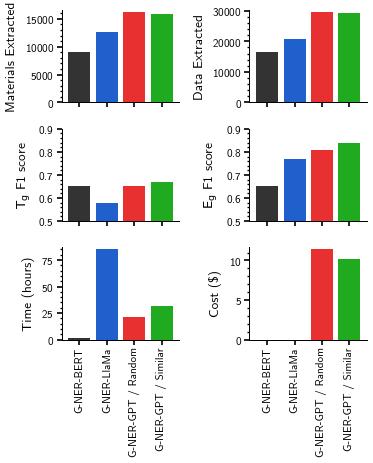

In [39]:
plt.rcParams['font.family'] = 'cursive'
colors = ["#333", "#2060cc", "#e93030", "#20aa20", "#8a5aca", "#00ddee", "m", "#e4a635"][:metrics.shape[0]]

fig, axes = plt.subplots(3, 2, figsize=(3.25, 4), sharex=True)
axes = axes.flatten()

barprops = dict(color=colors, align='center', width=0.8)

ax = axes[0]
metrics['materials'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='Materials Extracted')

ax = axes[1]
metrics['properties'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='Data Extracted')

ax = axes[2]
metrics['Tg'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='$T_g$ F1 score', ylim=(0.5, 0.9))

ax = axes[3]
metrics['Eg'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='$E_g$ F1 score', ylim=(0.5, 0.9))

ax = axes[4]
metrics['hours'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='Time (hours)')

ax = axes[5]
metrics['cost'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='Cost (\$)')


for ax in axes.flatten():
    ax.set(xlabel='')
    ax.tick_params(axis='x', which='minor', bottom=False)

plt.tight_layout()
plt.savefig("notebooks/Selec1k-Bars.eps")
plt.show()